In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.linalg import block_diag

In [2]:
# friction map:  [[0.09041 0.1     0.09041]
#                 [0.1     0.09041 0.09041]
#                 [0.1     0.1568  0.1    ]]

In [3]:
plt.close("all")

In [4]:
data = "../data/robot_data.csv"


In [5]:
df = pd.read_csv(data, index_col=0)

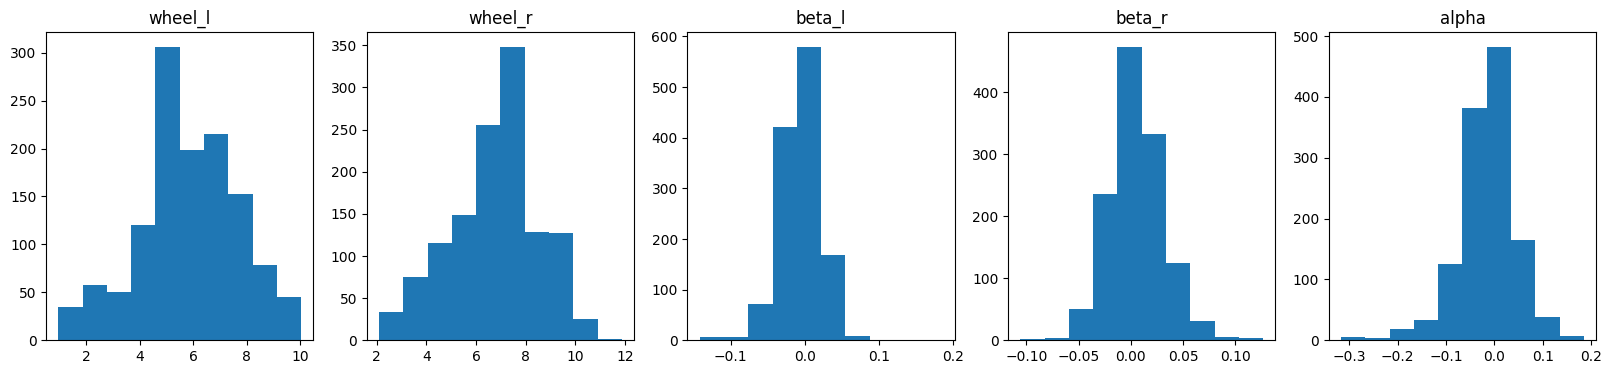

In [6]:
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
ax[0].hist(df.wheel_l)
ax[0].set_title('wheel_l')
ax[1].hist(df.wheel_r)
ax[1].set_title('wheel_r')
ax[2].hist(df.beta_l)
ax[2].set_title('beta_l')
ax[3].hist(df.beta_r)
ax[3].set_title('beta_r')
ax[4].hist(df.alpha)
ax[4].set_title('alpha')
plt.show()

In [7]:
df.wheel_l.min(), df.wheel_l.max()

(np.float64(0.9516313837640142), np.float64(10.03738646162457))

In [8]:
df.wheel_r.min(), df.wheel_r.max()

(np.float64(2.090139814654552), np.float64(11.881116932066586))

In [9]:
df

,wheel_l,wheel_r,beta_l,beta_r,alpha,i,j
0,1.836927,3.460789,-0.026558,-0.008111,0.053926,1,2
1,2.873038,4.404404,-0.003228,0.031594,0.042573,1,2
2,4.174108,5.313572,-0.006315,0.004810,0.126491,1,2
3,5.855450,6.404027,0.002131,0.001938,0.059251,1,2
4,6.534886,6.225993,-0.012277,-0.011820,0.004947,1,2
...,...,...,...,...,...,...,...
1255,6.210085,8.034897,-0.020900,-0.005422,-0.023036,0,2
1256,7.226314,8.260964,-0.051888,-0.038340,-0.046941,0,2
1257,7.840880,8.302377,0.006826,0.018153,-0.018506,0,2
1258,8.087973,7.921663,-0.002983,-0.009670,-0.026462,0,2


In [10]:
i_filter = 0
j_filter = 1

In [11]:
# filtered = df[(df.i == i_filter) & (df.j == j_filter)]
# filtered

filtered = df

In [12]:
filtered = filtered[(filtered.wheel_l >= 0)
                                    & (filtered.wheel_r >= 0)]
filtered = filtered[(filtered.wheel_l <= 11)
                    & (filtered.wheel_r <= 11)]

In [13]:
# filtered = filtered[(filtered.wheel_l > 9) & (filtered.wheel_r > 11)]
# filtered.sort_values(["wheel_l","wheel_r"])

In [14]:
omega_l = filtered.wheel_l.values
omega_r = filtered.wheel_r.values
beta_l = filtered.beta_l.values
beta_r = filtered.beta_r.values
alpha = filtered.alpha.values

In [15]:
# %matplotlib tk

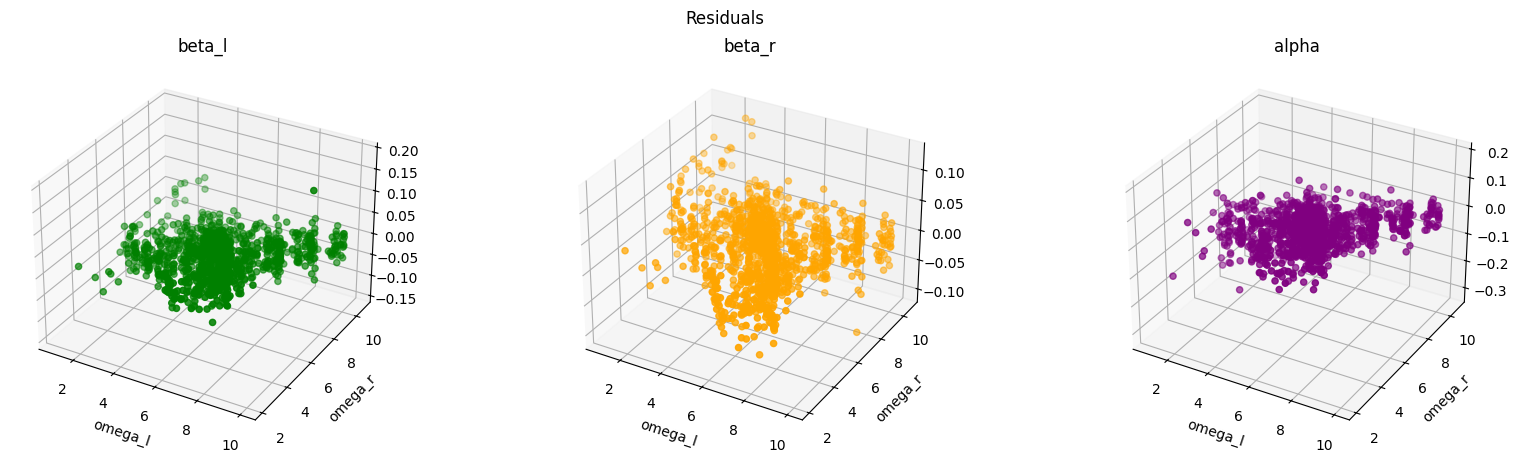

In [16]:
fig = plt.figure(figsize=(20, 5))
fig.suptitle("Residuals")

# Beta_l residuals
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(omega_l, omega_r, beta_l, color="green")
ax1.set_xlabel("omega_l")
ax1.set_ylabel("omega_r")
ax1.set_title("beta_l")
# ax1.view_init(0, 0, 0)

# Beta_r residuals
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(omega_l, omega_r, beta_r, color="orange")
ax2.set_xlabel("omega_l")
ax2.set_ylabel("omega_r")
ax2.set_title("beta_r")
# ax2.view_init(0, 0, 0)

# Alpha residuals
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(omega_l, omega_r, alpha, color="purple")
ax3.set_xlabel("omega_l")
ax3.set_ylabel("omega_r")
ax3.set_title("alpha")
# ax3.view_init(0, 0, 0)

plt.show()

In [17]:
degree = 3

In [18]:
# Initial OLS regression to get residuals
X = np.ones(len(omega_l))[:, np.newaxis]
for d in range(1, degree + 1):
    X = np.column_stack((X, omega_l**d, omega_r**d))
Y = np.column_stack((beta_l, beta_r, alpha))

In [19]:
# WLS regressor

weights_l = np.ones_like(Y[...,0])
weights_r = np.ones_like(Y[...,0])
weights_alpha = np.ones_like(Y[...,0])


W_l = np.diag(weights_l)
W_r = np.diag(weights_r)
W_alpha = np.diag(weights_alpha)

W = block_diag(W_l, W_r, W_alpha)

X_expanded = np.kron(np.eye(3), X)

XTWX_inv = np.linalg.inv(X_expanded.T @ W @ X_expanded)
XTWy = X_expanded.T @ W @ Y.flatten(order='F')
theta_hat_ols_flat = XTWX_inv @ XTWy

theta_hat_ols = theta_hat_ols_flat.reshape(3, -1).T
y_hat_ols = X @ theta_hat_ols

In [20]:
residuals_ols = Y - y_hat_ols

In [21]:
%matplotlib inline

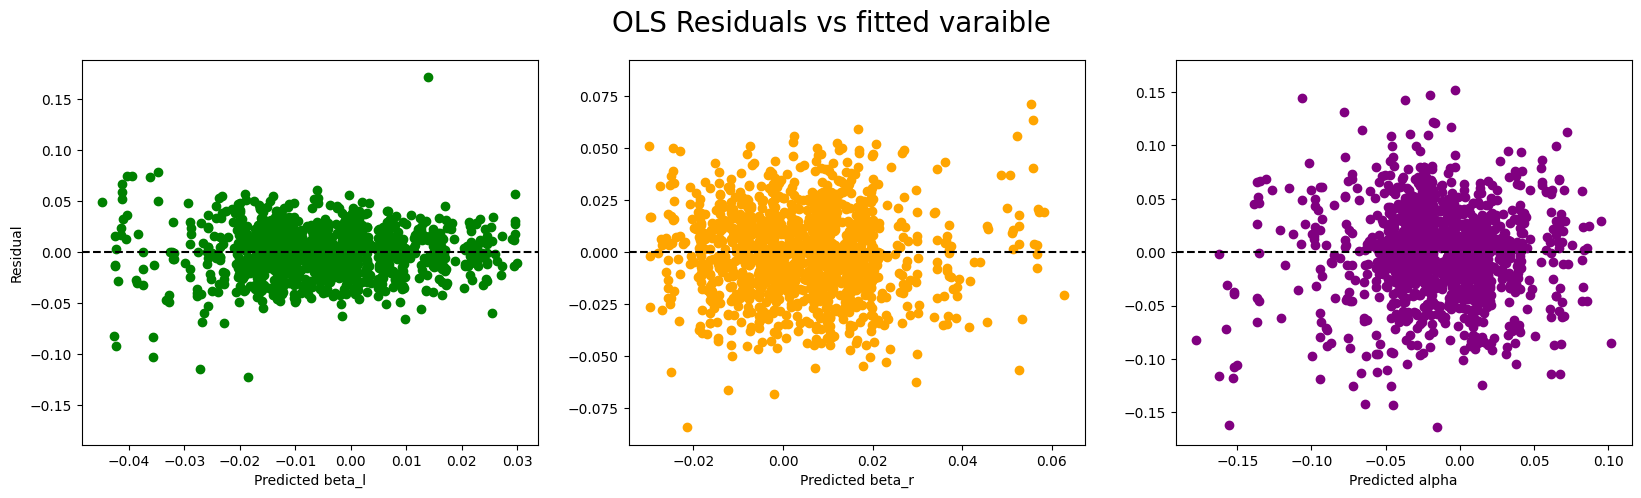

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
plt.suptitle("OLS Residuals vs fitted varaible", fontsize="20")

bound = max(abs(residuals_ols[...,0].min()),abs(residuals_ols[...,0].max()))
ax[0].set_ylim(-bound*1.1, bound*1.1)
ax[0].scatter(y_hat_ols[...,0], residuals_ols[...,0], color="green")
ax[0].axhline(0,linestyle='--', color='black')
ax[0].set_xlabel("Predicted beta_l")
ax[0].set_ylabel("Residual")

bound = max(abs(residuals_ols[...,1].min()),abs(residuals_ols[...,1].max()))
ax[1].set_ylim(-bound*1.1, bound*1.1)
ax[1].scatter(y_hat_ols[...,1], residuals_ols[...,1], color="orange")
ax[1].axhline(0,linestyle='--', color='black')
ax[1].set_xlabel("Predicted beta_r")

bound = max(abs(residuals_ols[...,2].min()),abs(residuals_ols[...,2].max()))
ax[2].set_ylim(-bound*1.1, bound*1.1)
ax[2].scatter(y_hat_ols[...,2], residuals_ols[...,2], color="purple")
ax[2].axhline(0,linestyle='--', color='black')
ax[2].set_xlabel("Predicted alpha")
plt.show()

In [23]:
iteration = 1

In [24]:
# Example data
omega_l = filtered.wheel_l.values
omega_r = filtered.wheel_r.values
beta_l = filtered.beta_l.values
beta_r = filtered.beta_r.values
alpha = filtered.alpha.values
Y = np.column_stack((beta_l, beta_r, alpha))

# Initial OLS regression to get residuals
X = np.ones(len(omega_l))[:, np.newaxis]
for d in range(1, degree + 1):
    X = np.column_stack((X, omega_l**d, omega_r**d))

# Initialize weights as OLS for the first iteration

weights_l = np.ones_like(Y[:, 0])
weights_r = np.ones_like(Y[:, 1])
weights_alpha = np.ones_like(Y[:, 2])

# Create individual diagonal weight matrices for each output
W_l = np.diag(weights_l)
W_r = np.diag(weights_r)
W_alpha = np.diag(weights_alpha)

# Combine these into a block diagonal matrix
W = block_diag(W_l, W_r, W_alpha)

for _ in range(iteration+1):

    X_expanded = np.kron(np.eye(3), X)
    F_0 = X_expanded.T @ W @ X_expanded
    a_0 = X_expanded.T @ W @ Y.flatten(order='F')
    # Now compute WLS using the expanded X and Y
    XTWX_inv = np.linalg.inv(F_0)
    XTWy = a_0
    theta_hat_wls = (XTWX_inv @ XTWy).reshape(3, -1).T

    y_hat_wls = X @ theta_hat_wls
    residuals_wls = Y - y_hat_wls

    # Estimate weights as the inverse of the residuals norm
    weights_l = 1 / np.abs(residuals_wls[:, 0] + 1e-10)
    weights_r = 1 / np.abs(residuals_wls[:, 1] + 1e-10)
    weights_alpha = 1 / np.abs(residuals_wls[:, 2] + 1e-10)

    # recompute weights matrix
    W_l = np.diag(weights_l)
    W_r = np.diag(weights_r)
    W_alpha = np.diag(weights_alpha)

    W = block_diag(W_l, W_r, W_alpha)


In [25]:
# std_residuals_beta_l = residuals_wls[:, 0] * np.sqrt(weights_l)
# std_residuals_beta_r = residuals_wls[:, 1] * np.sqrt(weights_r)
# std_residuals_alpha = residuals_wls[:, 2] * np.sqrt(weights_alpha)

std_residuals_beta_l = residuals_wls[:, 0] * weights_l
std_residuals_beta_r = residuals_wls[:, 1] * weights_r
std_residuals_alpha = residuals_wls[:, 2] * weights_alpha

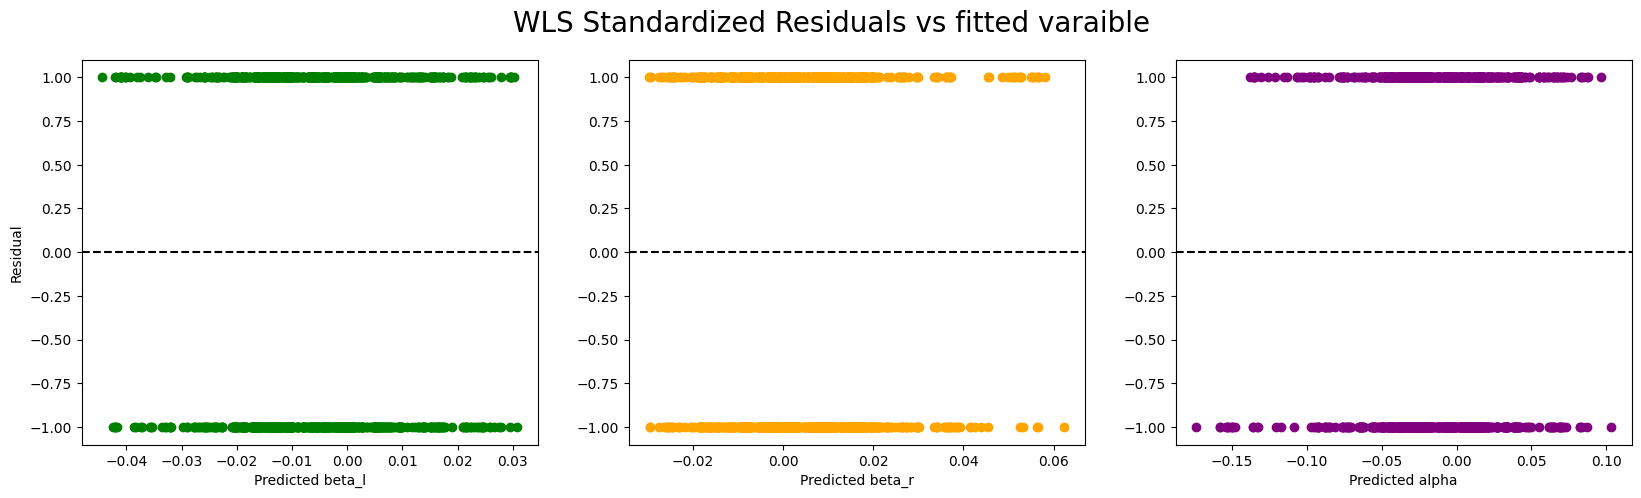

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
plt.suptitle("WLS Standardized Residuals vs fitted varaible", fontsize="20")

bound = max(abs(std_residuals_beta_l.min()),abs(std_residuals_beta_l.max()))
ax[0].set_ylim(-bound*1.1, bound*1.1)
ax[0].scatter(y_hat_wls[...,0], std_residuals_beta_l, color="green")
ax[0].axhline(0,linestyle='--', color='black')
ax[0].set_xlabel("Predicted beta_l")
ax[0].set_ylabel("Residual")

bound = max(abs(std_residuals_beta_r.min()),abs(std_residuals_beta_r.max()))
ax[1].set_ylim(-bound*1.1, bound*1.1)
ax[1].scatter(y_hat_wls[...,1], std_residuals_beta_r, color="orange")
ax[1].axhline(0,linestyle='--', color='black')
ax[1].set_xlabel("Predicted beta_r")

bound = max(abs(std_residuals_alpha.min()),abs(std_residuals_alpha.max()))
ax[2].set_ylim(-bound*1.1, bound*1.1)
ax[2].scatter(y_hat_wls[...,2], std_residuals_alpha, color="purple")
ax[2].axhline(0,linestyle='--', color='black')
ax[2].set_xlabel("Predicted alpha")
plt.show()

In [27]:
%matplotlib tk

In [28]:
fig = plt.figure(figsize=(20, 5))
fig.suptitle("Data")

# Beta_l residuals
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(omega_l, omega_r, beta_l, color="green")
ax1.scatter(omega_l, omega_r, y_hat_ols[...,0], color="blue")
ax1.scatter(omega_l, omega_r, y_hat_wls[...,0], color="red")
ax1.set_xlabel("omega_l")
ax1.set_ylabel("omega_r")
ax1.set_title("beta_l")
# ax1.view_init(0, 0, 0)

# Beta_r residuals
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(omega_l, omega_r, beta_r, color="orange")
ax2.scatter(omega_l, omega_r, y_hat_ols[...,1], color="blue")
ax2.scatter(omega_l, omega_r, y_hat_wls[...,1], color="red")
ax2.set_xlabel("omega_l")
ax2.set_ylabel("omega_r")
ax2.set_title("beta_r")
# ax2.view_init(0, 0, 0)

# Alpha residuals
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(omega_l, omega_r, alpha, color="purple")
ax3.scatter(omega_l, omega_r, y_hat_ols[...,2], color="blue")
ax3.scatter(omega_l, omega_r, y_hat_wls[...,2], color="red")
ax3.set_xlabel("omega_l")
ax3.set_ylabel("omega_r")
ax3.set_title("alpha")
# ax3.view_init(0, 0, 0)

plt.show()

In [29]:
# Extract coefficients from WLS estimation
# Coefficients for beta_l
theta_0_l, theta_1_l, theta_2_l, theta_3_l, theta_4_l, theta_5_l, theta_6_l = theta_hat_wls[
    :, 0]
# Coefficients for beta_r
theta_0_r, theta_1_r, theta_2_r, theta_3_r, theta_4_r, theta_5_r, theta_6_r = theta_hat_wls[
    :, 1]
# Coefficients for alpha
theta_0_alpha, theta_1_alpha, theta_2_alpha, theta_3_alpha, theta_4_alpha, theta_5_alpha, theta_6_alpha = theta_hat_wls[
    :, 2]

# Create a grid of values for omega_l and omega_r
omega_l_grid, omega_r_grid = np.meshgrid(np.linspace(omega_l.min(), omega_l.max(), 10),
                                         np.linspace(omega_r.min(), omega_r.max(), 10))

# Calculate the corresponding beta_l, beta_r, and alpha values on the grid
beta_l_grid_wls = theta_0_l + theta_1_l * omega_l_grid + theta_2_l * omega_r_grid + theta_3_l * \
    omega_l_grid**2 + theta_4_l * omega_r_grid**2 + \
    theta_5_l * omega_l_grid**3 + theta_6_l * omega_r_grid**3

beta_r_grid_wls = theta_0_r + theta_1_r * omega_l_grid + theta_2_r * omega_r_grid + theta_3_r * \
    omega_l_grid**2 + theta_4_r * omega_r_grid**2 + \
    theta_5_r * omega_l_grid**3 + theta_6_r * omega_r_grid**3

alpha_grid_wls = theta_0_alpha + theta_1_alpha * omega_l_grid + theta_2_alpha * omega_r_grid + theta_3_alpha * \
    omega_l_grid**2 + theta_4_alpha * omega_r_grid**2 + \
    theta_5_alpha * omega_l_grid**3 + theta_6_alpha * omega_r_grid**3

In [30]:
fig = plt.figure(figsize=(20, 5))
fig.suptitle("Residuals")



# Beta_l residuals
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(omega_l, omega_r, beta_l, color="green")
ax1.scatter(omega_l, omega_r, y_hat_ols[...,0], color="blue")
ax1.scatter(omega_l, omega_r, y_hat_wls[...,0], color="red")
ax1.plot_surface(omega_l_grid, omega_r_grid, beta_l_grid_wls, alpha=1)
ax1.set_xlabel("omega_l")
ax1.set_ylabel("omega_r")
ax1.set_title("beta_l")
# ax1.view_init(0, 0, 0)

# Beta_r residuals
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(omega_l, omega_r, beta_r, color="orange")
ax2.scatter(omega_l, omega_r, y_hat_ols[...,1], color="blue")
ax2.scatter(omega_l, omega_r, y_hat_wls[...,1], color="red")
ax2.plot_surface(omega_l_grid, omega_r_grid, beta_r_grid_wls, alpha=1)
ax2.set_xlabel("omega_l")
ax2.set_ylabel("omega_r")
ax2.set_title("beta_r")
# ax2.view_init(0, 0, 0)

# Alpha residuals
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(omega_l, omega_r, alpha, color="purple")
ax3.scatter(omega_l, omega_r, y_hat_ols[...,2], color="blue")
ax3.scatter(omega_l, omega_r, y_hat_wls[...,2], color="red")
ax3.plot_surface(omega_l_grid, omega_r_grid, alpha_grid_wls, alpha=1)
ax3.set_xlabel("omega_l")
ax3.set_ylabel("omega_r")
ax3.set_title("alpha")
# ax3.view_init(0, 0, 0)

plt.show()

In [31]:
print(f"beta_l r2: ols={r2_score(Y[...,0], y_hat_ols[...,0])}, wls={r2_score(Y[...,0], y_hat_wls[...,0])}")
print(f"beta_r r2: ols={r2_score(Y[...,1], y_hat_ols[...,1])}, wls={r2_score(Y[...,1], y_hat_wls[...,1])}")
print(f"alpha r2: ols={r2_score(Y[...,2], y_hat_ols[...,2])}, wls={r2_score(Y[...,2], y_hat_wls[...,2])}")

beta_l r2: ols=0.245779249588715, wls=0.24566603932832654
beta_r r2: ols=0.346266874750503, wls=0.3462497229212964
alpha r2: ols=0.4600172152154324, wls=0.4598643827393838


In [32]:
df_1 = pd.read_csv("data/1.csv", index_col=0) 

In [33]:
%matplotlib tk

In [34]:
fig = plt.figure(figsize=(20, 5))
fig.suptitle("Residuals")

omega_l_gt = df_1.wheel_l.values
omega_r_gt = df_1.wheel_r.values
beta_l_gt = df_1.beta_l.values
beta_r_gt = df_1.beta_r.values
alpha_gt = df_1.alpha.values

# Beta_l residuals
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(omega_l_gt, omega_r_gt, beta_l_gt, color="green")
ax1.scatter(omega_l, omega_r, beta_l, color="gray")
ax1.plot_surface(omega_l_grid, omega_r_grid, beta_l_grid_wls, alpha=1)
ax1.set_xlabel("omega_l")
ax1.set_ylabel("omega_r")
ax1.set_title("beta_l")
# ax1.view_init(0, 0, 0)

# Beta_r residuals
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(omega_l_gt, omega_r_gt, beta_r_gt, color="orange")
ax2.scatter(omega_l, omega_r, beta_r, color="gray")
ax2.plot_surface(omega_l_grid, omega_r_grid, beta_r_grid_wls, alpha=1)
ax2.set_xlabel("omega_l")
ax2.set_ylabel("omega_r")
ax2.set_title("beta_r")
# ax2.view_init(0, 0, 0)

# Alpha residuals
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(omega_l_gt, omega_r_gt, alpha_gt, color="purple")
ax3.scatter(omega_l, omega_r, alpha, color="gray")
ax3.plot_surface(omega_l_grid, omega_r_grid, alpha_grid_wls, alpha=1)
ax3.set_xlabel("omega_l")
ax3.set_ylabel("omega_r")
ax3.set_title("alpha")
# ax3.view_init(0, 0, 0)

plt.show()

In [35]:
X = np.ones(len(omega_l_gt))[:, np.newaxis]
for d in range(1, degree + 1):
    X = np.column_stack((X, omega_l_gt**d, omega_r_gt**d))
    
Y = np.column_stack((beta_l_gt, beta_r_gt, alpha_gt))

In [36]:
y_hat_wls_gt = X @ theta_hat_wls

In [37]:
fig = plt.figure(figsize=(20, 5))
fig.suptitle("Data")

# Beta_l residuals
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(omega_l_gt, omega_r_gt, beta_l_gt, color="green")
ax1.scatter(omega_l_gt, omega_r_gt, y_hat_wls_gt[...,0], color="red")
ax1.set_xlabel("omega_l")
ax1.set_ylabel("omega_r")
ax1.set_title("beta_l")
# ax1.view_init(0, 0, 0)

# Beta_r residuals
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(omega_l_gt, omega_r_gt, beta_r_gt, color="orange")
ax2.scatter(omega_l_gt, omega_r_gt, y_hat_wls_gt[...,1], color="red")
ax2.set_xlabel("omega_l")
ax2.set_ylabel("omega_r")
ax2.set_title("beta_r")
# ax2.view_init(0, 0, 0)

# Alpha residuals
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(omega_l_gt, omega_r_gt, alpha_gt, color="purple")
ax3.scatter(omega_l_gt, omega_r_gt, y_hat_wls_gt[...,2], color="red")
ax3.set_xlabel("omega_l")
ax3.set_ylabel("omega_r")
ax3.set_title("alpha")
# ax3.view_init(0, 0, 0)

plt.show()

In [38]:
print(f"beta_l_gt r2: wls={r2_score(Y[...,0], y_hat_wls_gt[...,0])}")
print(f"beta_r_gt r2: wls={r2_score(Y[...,1], y_hat_wls_gt[...,1])}")
print(f"alpha_gt r2: wls={r2_score(Y[...,2], y_hat_wls_gt[...,2])}")

beta_l_gt r2: wls=0.7897373633451853
beta_r_gt r2: wls=0.9016975222345867
alpha_gt r2: wls=0.815757656625344


In [39]:
theta_hat_ols, theta_hat_wls

(array([[-7.38673065e-03,  2.99429035e-02,  5.79087682e-02],
        [ 1.23140417e-02, -1.85876551e-02,  5.23319427e-02],
        [-4.51463158e-03,  4.99616085e-03, -8.78050370e-02],
        [-1.32804623e-03,  2.16717674e-03, -6.21270575e-03],
        [-5.48906723e-04, -3.04603432e-04,  1.26240670e-02],
        [ 7.53175600e-05, -1.17732761e-04,  3.25396492e-04],
        [ 4.77497171e-05,  3.64983797e-05, -6.78867333e-04]]),
 array([[-3.81110840e-03,  3.20383281e-02,  5.99321868e-02],
        [ 1.10966316e-02, -1.86867930e-02,  5.17594792e-02],
        [-5.48023608e-03,  3.92908260e-03, -8.74278980e-02],
        [-1.04782609e-03,  2.20104030e-03, -6.03741682e-03],
        [-4.23011359e-04, -1.34994456e-04,  1.23814138e-02],
        [ 5.64991296e-05, -1.20278706e-04,  3.10906375e-04],
        [ 4.28541669e-05,  2.79068951e-05, -6.57133549e-04]]))